In [1]:
import tensorflow as tf
import nltk
#nltk.download('wordnet')
#nltk.download('punkt')
import json
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from random import shuffle, choice

In [2]:
print(tf.__version__)

2.5.0


In [3]:
lemma = nltk.wordnet.WordNetLemmatizer()

with open("intents.json") as json_data:
    intents = json.load(json_data)

In [4]:
ignore = [".", "?","!",","]
words = [] # Stores unique words
dictionary = {} # Stores tags along with lemmatized patterns

for intent in intents["intents"]:
    for pattern in intent["patterns"]:
        #print(pattern)
        tokens = nltk.word_tokenize(pattern)
        #print(tokens)
        token_words = [lemma.lemmatize(w.lower(), pos="v") for w in tokens if w not in ignore] # Lemmatize the words
        #print(token_words)
        if (intent["tag"] not in list(dictionary.keys())):
            dictionary[intent["tag"]] = [token_words]
        else:
            dictionary[intent["tag"]].append(token_words)
        words.extend(token_words)
classes = list(dictionary.keys())
words = np.sort(np.unique(words))
np.save("classes"+'.npy', classes)
np.save("words"+'.npy', words)

In [5]:
print(f"Classes: {classes}, Length:{len(classes)}")
print("-"*125)
print(f"Words: {words}, Length: {len(words)}")
print("-"*125)
for key, value in dictionary.items():
    print(f"{key}: {value}\n")

Classes: ['greeting', 'positive', 'fine', 'identity', 'help', 'options', 'goodbye', 'thanks', 'time', 'rolled', 'bored', 'sad', 'encouragement', 'jokes', 'fact', 'dogfact', 'catfact', 'cutecat', 'cutedog', 'cute', 'quote', 'news', 'healthnews', 'sportsnews', 'businessnews', 'technologynews', 'entertainmentnews'], Length:27
-----------------------------------------------------------------------------------------------------------------------------
Words: ["'s" 'a' 'an' 'any' 'anyone' 'awesome' 'be' 'bore' 'business' 'bye' 'ca'
 'can' 'candice' 'cat' 'catch' 'celebrity' 'chat' 'crack' 'cute' 'day'
 'deez' 'do' 'dog' 'down' 'dragons' 'enlighten' 'entertainment' 'fact'
 'feel' 'fine' 'for' 'funny' 'game' 'give' 'go' 'good' 'goodbye' 'great'
 'hang' 'happen' 'happy' 'have' 'health' 'hello' 'help' 'helpful' 'hey'
 'hi' 'how' 'i' 'imagine' 'in' 'inspirational' 'interest' 'it' 'job'
 'joke' 'just' 'later' 'latest' 'like' 'lot' 'love' 'me' 'medical'
 'medicine' 'mood' 'much' 'myself' "n't" 'nam

In [6]:
# Returns a binary encoded label for each class
def get_label(category): # I love you get_lable function uwu
    label = np.zeros((len(classes),), dtype=int)
    for item in classes:
        if (item == category):
            label[classes.index(category)] = 1
            return label
        
def gen_data(fileName = None):
    data = []
    for tag, patterns in dictionary.items():
        label = get_label(tag)
        for pattern in patterns:
            #print(pattern)
            bag = []
            for w in words:
                if w in pattern:
                    bag.append(1)
                else:
                    bag.append(0)
            data.append([np.array(bag), label])
    shuffle(data)
    if fileName is not None:
        np.save(fileName+'.npy', data)
    return np.array(data)

In [7]:
train_data = gen_data()

C:\Users\sudhe\.conda\envs\chatbot-tf\lib\site-packages\ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
print(train_data.shape)

(152, 2)


In [9]:
X_train = np.array([i[0] for i in train_data])
Y_train = np.array([i[1] for i in train_data])

In [10]:
print(X_train.shape[1:])

(118,)


In [11]:
model = Sequential()
model.add(Dense(128, input_shape=X_train.shape[1:], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               15232     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1755      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
_________________________________________________________________


In [13]:
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint('./models/model-{epoch:03d}.model', monitor='loss', verbose=0, save_best_only = True,
                             mode = 'auto')
history = model.fit(X_train, Y_train, epochs = 200, callbacks = [checkpoint], batch_size=5, verbose=1)

Epoch 1/200
31/31 [==============================] - 2s 3ms/step - loss: 3.3035 - accuracy: 0.0724
INFO:tensorflow:Assets written to: ./models\model-001.model\assets
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 3.2274 - accuracy: 0.0855
INFO:tensorflow:Assets written to: ./models\model-002.model\assets
Epoch 3/200
31/31 [==============================] - 0s 2ms/step - loss: 3.1817 - accuracy: 0.0921
INFO:tensorflow:Assets written to: ./models\model-003.model\assets
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 3.0957 - accuracy: 0.1118
INFO:tensorflow:Assets written to: ./models\model-004.model\assets
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 3.0124 - accuracy: 0.1513
INFO:tensorflow:Assets written to: ./models\model-005.model\assets
Epoch 6/200
31/31 [==============================] - 0s 2ms/step - loss: 2.8229 - accuracy: 0.2566
INFO:tensorflow:Assets written to: ./models\model-006.model\assets
Epoc

Epoch 137/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0788 - accuracy: 0.9868
Epoch 138/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0858 - accuracy: 0.9737
Epoch 139/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.9605
Epoch 140/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1234 - accuracy: 0.9671
Epoch 141/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1075 - accuracy: 0.9803
Epoch 142/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1336 - accuracy: 0.9474
Epoch 143/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1017 - accuracy: 0.9737
Epoch 144/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1267 - accuracy: 0.9539
Epoch 145/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1452 - accuracy: 0.9605
Epoch 146/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1635 - accurac

In [15]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()

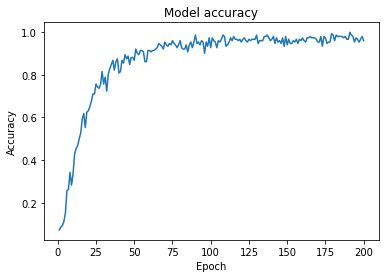

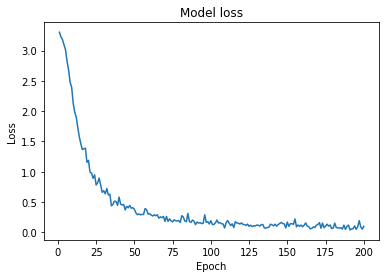

In [16]:
plot_learningCurve(history, 200)

In [17]:
def encode_sentence(sentence):
    bag = []
    # Tokenize and lemmatize (I'm lemmatizing)
    tokens = nltk.word_tokenize(sentence)
    token_words = [lemma.lemmatize(w.lower(), pos="v") for w in tokens if w not in ignore]
    for w in words:
        if w in token_words:
            bag.append(1)
        else:
            bag.append(0)
    return np.array(bag)

def get_response(sentence):
    sentence = encode_sentence(sentence)
    comparison = sentence == np.array([0]*len(words))
    if (comparison.all()):
        for intent in intents["intents"]:
            if intent["tag"] == "noanswer":
                return choice(intent["responses"])
    result = model.predict(sentence.reshape(-1,118))
    tag = classes[np.argmax(result, axis=1)[0]]
    for intent in intents["intents"]:
        if intent["tag"] == tag:
            return choice(intent["responses"])

In [18]:
sentence = encode_sentence("idk say a cat fact or something")
print(sentence)

[0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [19]:
result = model.predict(sentence.reshape(-1,118))
print(classes[np.argmax(result, axis=1)[0]])

catfact


In [20]:
get_response("I dont feel so good")

'I know you probably do not feel like it right now but just go take a walk outside.'

In [24]:
get_response("sefsefdsfwqqasad dadwasda")

'Godzilla had a stroke trying to read that.'